# Inferenz Notebook
In diesem Notebook können die Modelle auf selbst ausgewählten Pokemon getestet werden.

In [6]:
import torch
import numpy as np
import pandas as pd
import os
import random
from IPython.display import Image
from scipy.special import softmax
np.set_printoptions(suppress=True)

In [7]:
numpy_data_path = "../../../pokemonData/Training-baseline/"
image_data_path = "../../../pokemonData/pokemonDataset/"

# load saved model
model = torch.load("./saved-models/15Epochs-noFreeze-CrossE.pt")
# make sure it is on the cpu, not the gpu
model = model.cpu()
# switch to eval mode, turn off dropout, batchnorm etc.
model.eval()

metadata = pd.read_csv('metadata/pokemon.csv')

# create dataframe with type and corresponding index in the one hot encoding vector
filtered_metadata = metadata.loc[:,['name', 'type1']]
filtered_metadata.type1 = pd.Categorical(filtered_metadata.type1)
filtered_metadata['code'] = filtered_metadata.type1.cat.codes
filtered_metadata = filtered_metadata[["type1", "code"]].drop_duplicates()

In [8]:
# returns type for a pokemon name -> input:Bulbasaur output:grass
def get_type_for_name(name):
    return metadata[metadata["name"] == name]["type1"].values[0]

# returns type for index of one hot encoding vector -> input: 6 output:grass
def extract_type(idx):
    return filtered_metadata[filtered_metadata["code"] == idx]["type1"].values[0]

In [9]:
def make_prediction(name):
    numpy_files = os.listdir(numpy_data_path+name)
    image_files = os.listdir(image_data_path+name)
    # select random file in the pokemon folder
    file_idx = random.choice(list(enumerate(numpy_files)))[0]
    display(Image(filename=image_data_path+name+"/"+image_files[file_idx], width = 500, height = 300))
    # load image from pokemon folder
    image_array = np.load(numpy_data_path+name+"/"+numpy_files[file_idx])[:,:,:3]
    data = image_array.astype(np.float32)
    
    # transpose input data
    data = data.transpose()
    # add batch dimension
    data = data[None,:,:,:]
    data = torch.tensor(data, dtype=torch.float)
    # get prediction for input
    prediction = model(data).detach().numpy()[0]

    confident_idx = np.argmax(prediction)
    print(f"Model predicted: {extract_type(confident_idx)}")
    print(f"Pokemon type is: {get_type_for_name(name)}")
    # list all type predictions, sorted descending
    prediction = [(extract_type(idx), single_prediction) for idx, single_prediction in enumerate((softmax(prediction)*100))]
    prediction.sort(key=lambda x: x[1], reverse=True)
    prediction = [f"{single_prediction[0]}: {single_prediction[1]:.2f}%" for single_prediction in prediction]
    
    for idx, single_prediction in enumerate(prediction):
        print(single_prediction, end='\t')
        if (idx + 1) % 6 == 0:
            print("")

Gewünschte Pokemon in der test_pokemon_list hinzufügen (in Englisch, mehrfach auflisten ist möglich)

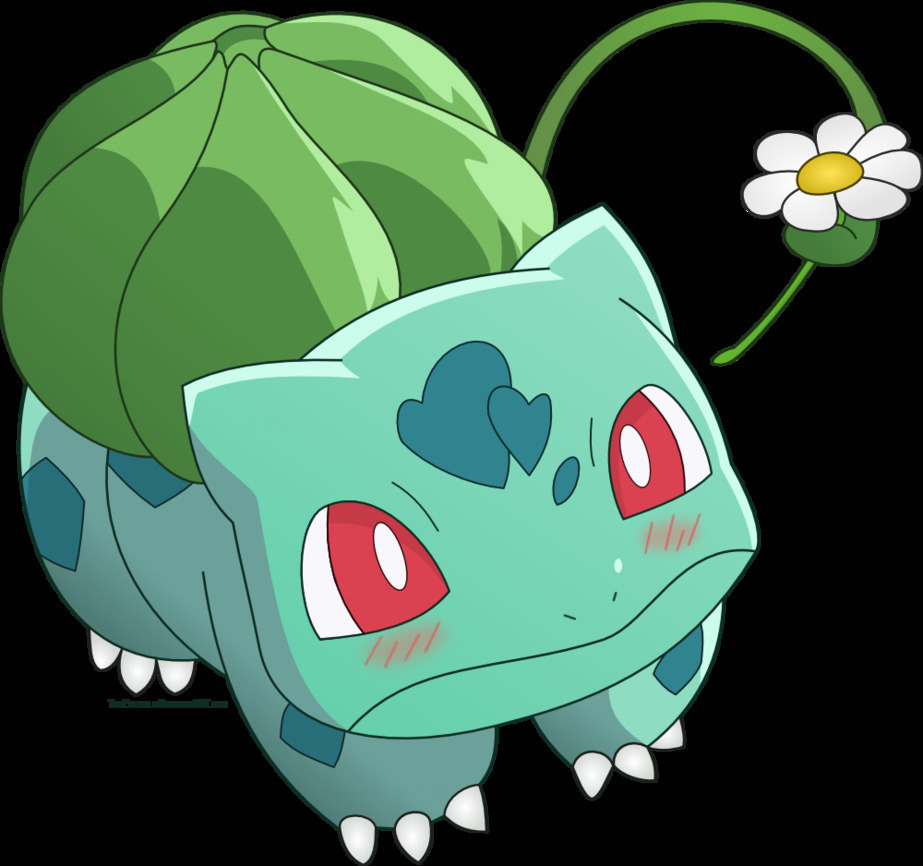

Model predicted: grass
Pokemon type is: grass
grass: 44.69%	rock: 22.20%	poison: 17.29%	bug: 11.08%	water: 2.62%	psychic: 0.68%	
ground: 0.62%	ghost: 0.22%	normal: 0.16%	dragon: 0.16%	steel: 0.12%	fighting: 0.06%	
ice: 0.04%	fairy: 0.03%	electric: 0.02%	fire: 0.01%	dark: 0.01%	flying: 0.01%	


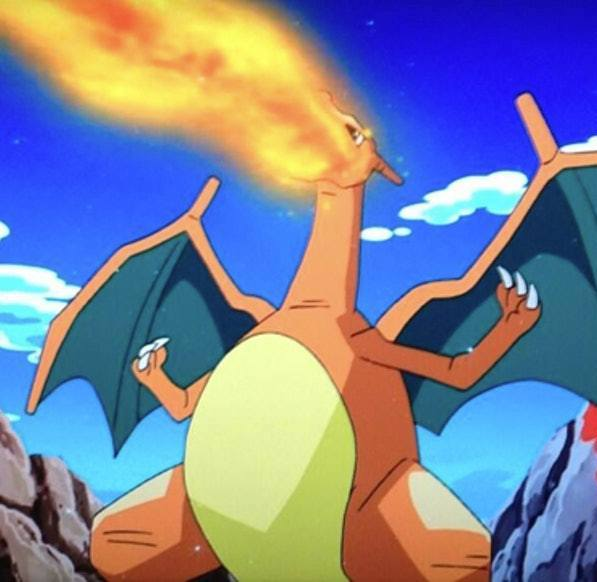

Model predicted: fire
Pokemon type is: fire
fire: 96.74%	normal: 1.96%	dark: 0.59%	psychic: 0.21%	dragon: 0.20%	fighting: 0.09%	
water: 0.07%	ground: 0.04%	electric: 0.03%	rock: 0.03%	grass: 0.02%	ice: 0.02%	
bug: 0.00%	fairy: 0.00%	poison: 0.00%	ghost: 0.00%	steel: 0.00%	flying: 0.00%	


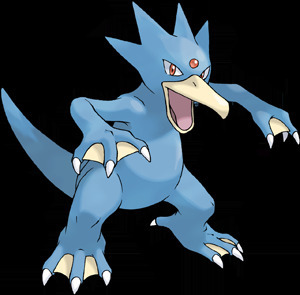

Model predicted: water
Pokemon type is: water
water: 99.99%	dragon: 0.01%	ice: 0.00%	normal: 0.00%	poison: 0.00%	bug: 0.00%	
steel: 0.00%	rock: 0.00%	psychic: 0.00%	ground: 0.00%	fighting: 0.00%	dark: 0.00%	
fairy: 0.00%	electric: 0.00%	grass: 0.00%	fire: 0.00%	ghost: 0.00%	flying: 0.00%	


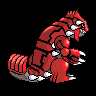

Model predicted: ground
Pokemon type is: ground
ground: 67.59%	dragon: 10.22%	rock: 6.93%	fire: 4.53%	dark: 3.96%	bug: 3.52%	
poison: 0.74%	fighting: 0.61%	steel: 0.50%	water: 0.48%	ghost: 0.35%	normal: 0.15%	
grass: 0.09%	ice: 0.08%	electric: 0.08%	psychic: 0.07%	fairy: 0.05%	flying: 0.05%	


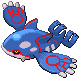

Model predicted: water
Pokemon type is: water
water: 51.55%	steel: 17.39%	rock: 13.47%	bug: 12.50%	poison: 3.16%	dragon: 0.52%	
ground: 0.50%	ghost: 0.23%	normal: 0.15%	ice: 0.11%	dark: 0.09%	grass: 0.08%	
psychic: 0.06%	electric: 0.05%	fighting: 0.05%	fire: 0.04%	fairy: 0.03%	flying: 0.01%	


In [10]:
test_pokemon_list = ["Bulbasaur", "Charizard", "Golduck", "Groudon", "Kyogre"]
for pokemon in test_pokemon_list:
    make_prediction(pokemon)

## Vergleich - Verschiedene Modelle

In [13]:
def make_prediction(name, net_list):
    numpy_files = os.listdir(numpy_data_path+name)
    image_files = os.listdir(image_data_path+name)
    # select random file in the pokemon folder
    file_idx = random.choice(list(enumerate(numpy_files)))[0]
    display(Image(filename=image_data_path+name+"/"+image_files[file_idx], width = 250, height = 100))
    # load image from pokemon folder
    image_array = np.load(numpy_data_path+name+"/"+numpy_files[file_idx])[:,:,:3]
    data = image_array.astype(np.float32)
    # transpose input data
    data = data.transpose()
    # add batch dimension
    data = data[None,:,:,:]
    data = torch.tensor(data, dtype=torch.float)
    print(f"Pokemon type is: {get_type_for_name(name)}")

    for net in net_list:
        # extract model name
        name = net.split("/")[2][:-3]
        model = torch.load(net)
        model = model.cpu()
        model.eval()

        prediction = model(data).detach().numpy()[0]
        prediction = [(extract_type(idx), single_prediction) for idx, single_prediction in enumerate((softmax(prediction)*100))]
        prediction.sort(key=lambda x: x[1], reverse=True)
        prediction = prediction[:5]
        # fill type strings to align rows
        double_point = ":"
        prediction = [f"{(single_prediction[0]+double_point).ljust(10)} {single_prediction[1]:.2f}%" for single_prediction in prediction]
        
        print(f"{name}")
        for idx, single_prediction in enumerate(prediction):
            print(single_prediction, end='\t')
        print("")

Verglichen werden die Top 5 vorhergesagten Typen jedes Modells. Unter den Modellen sind: nur den Klassifikationsteil Fine Tuned, das komplette Modell Fine Tuned und zuletzt noch das Baseline Beispiel ohne Pretraining.

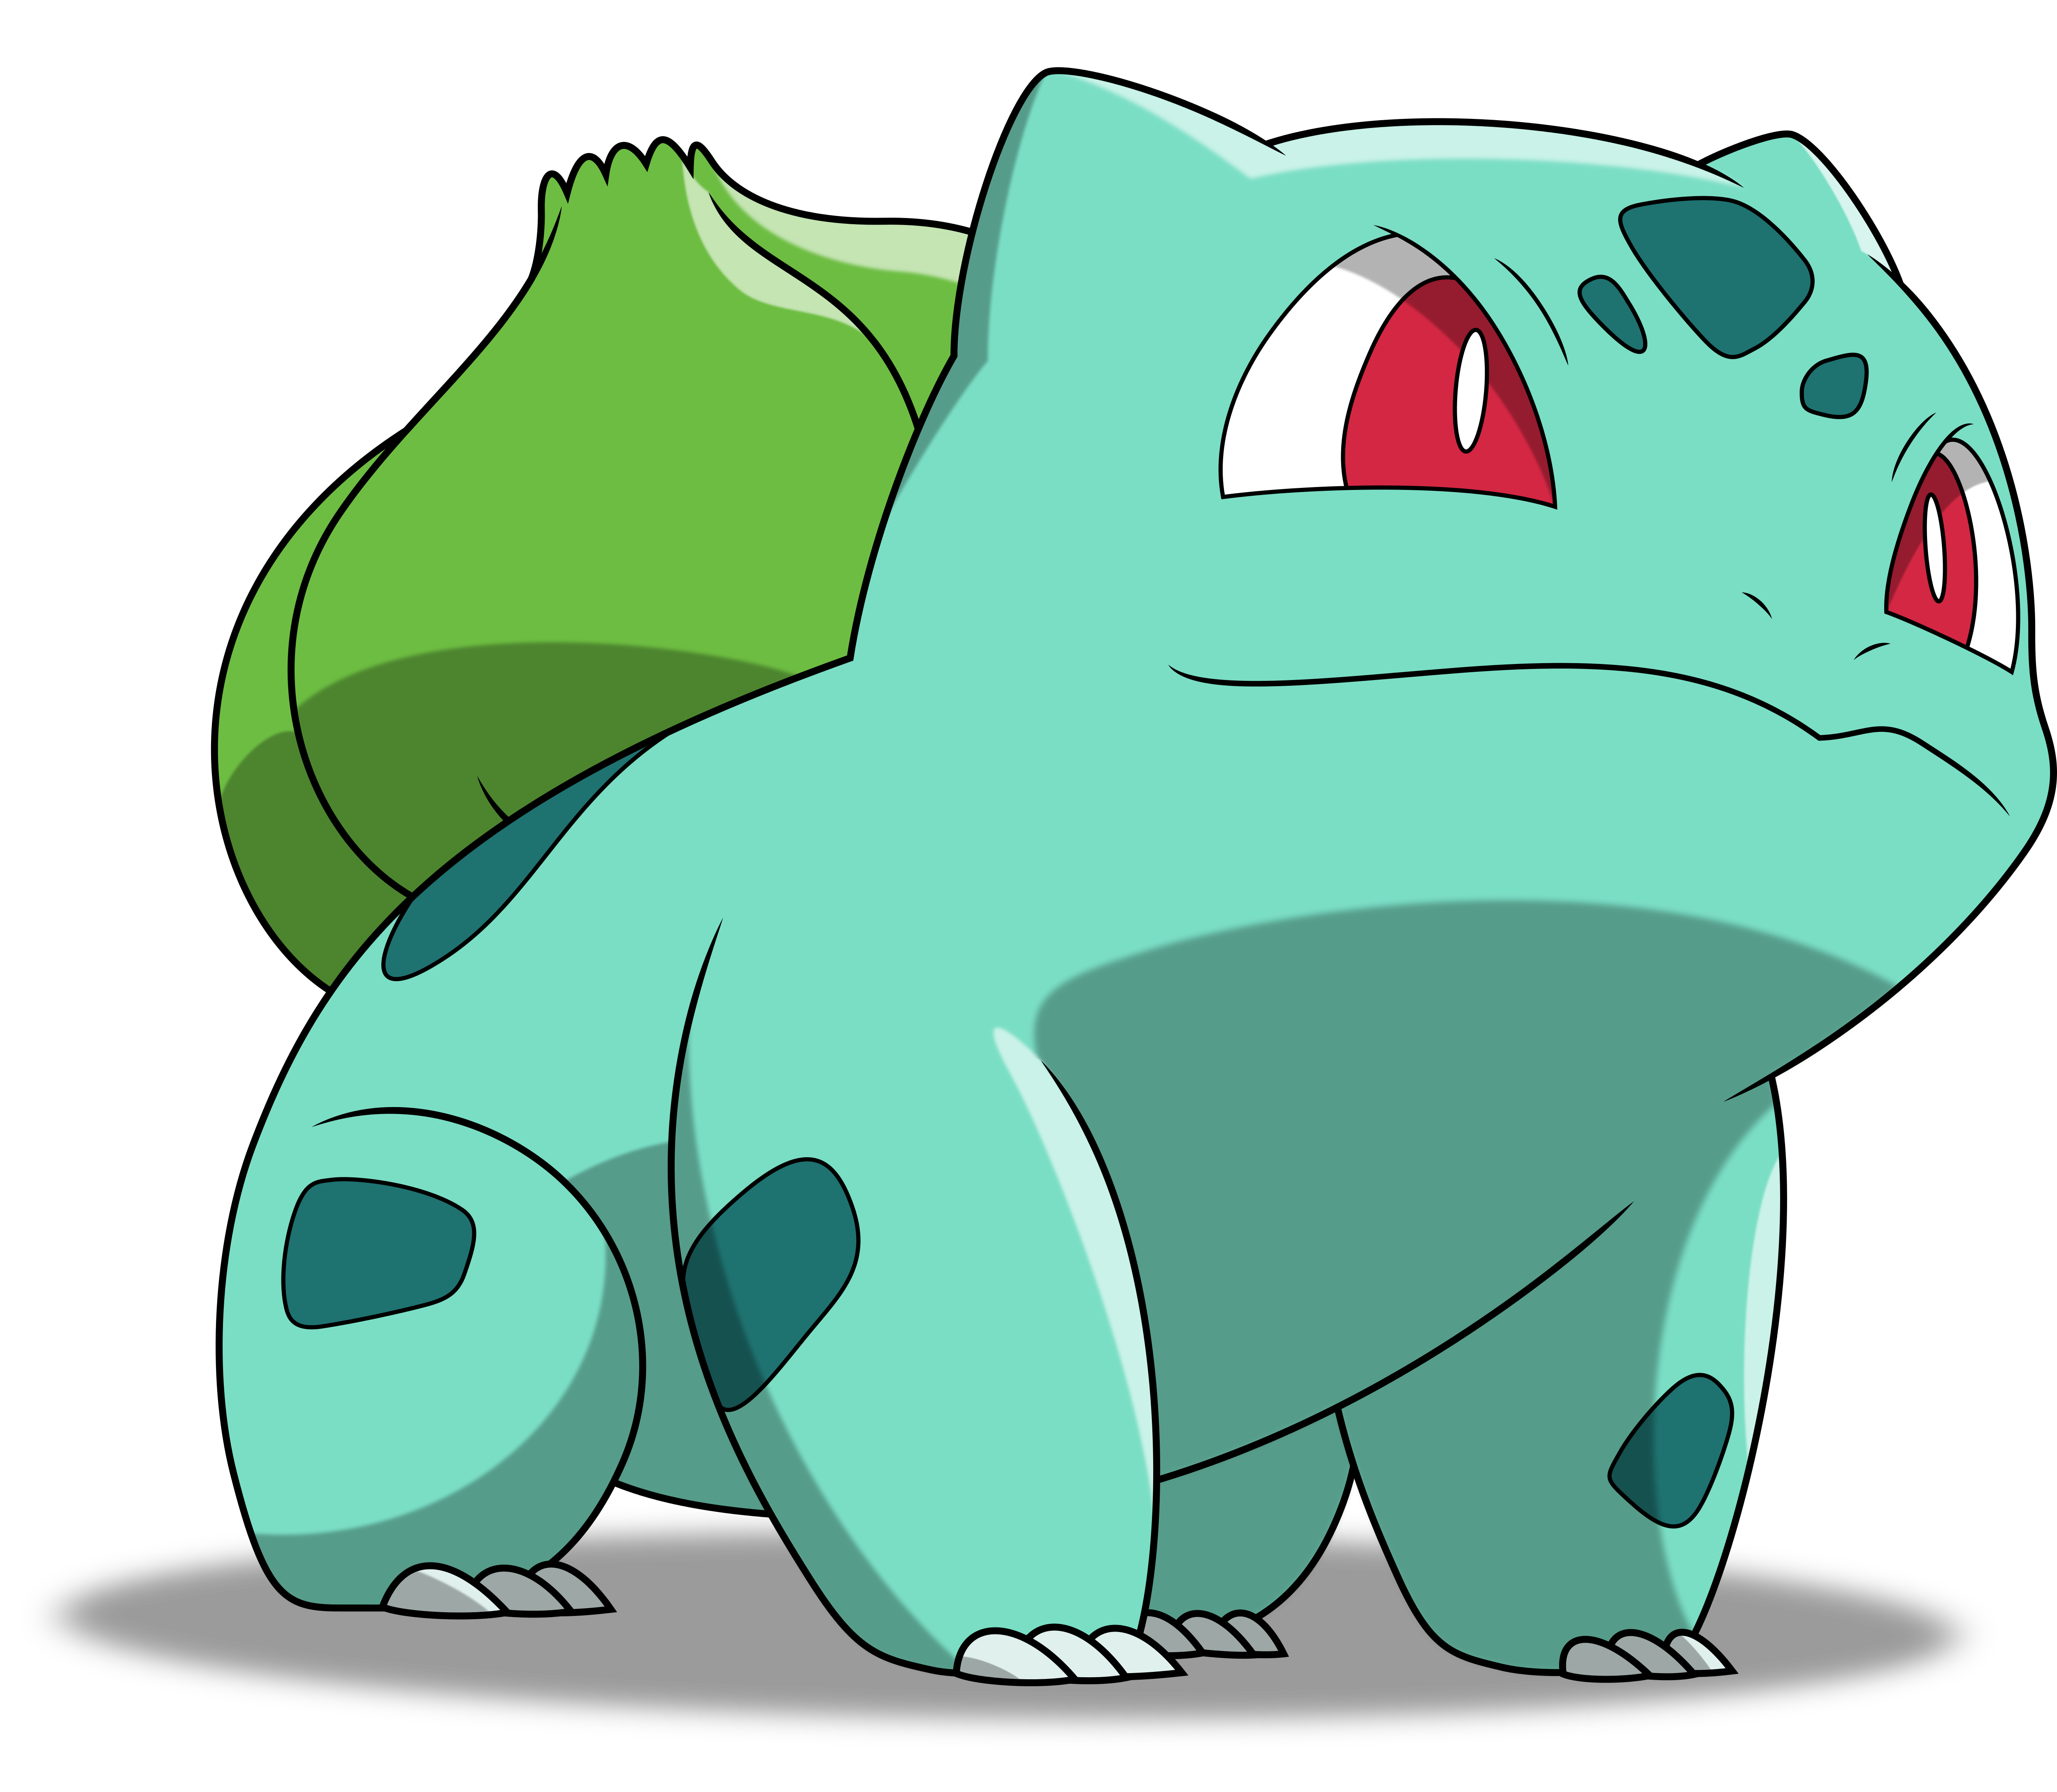

Pokemon type is: grass
freeze-customLR
grass:     82.55%	normal:    5.40%	fire:      3.10%	water:     2.60%	psychic:   1.42%	
15Epochs-noFreeze-CrossE
grass:     99.15%	poison:    0.35%	bug:       0.16%	rock:      0.12%	ground:    0.07%	
no-pretrain-customLR
grass:     53.57%	bug:       16.77%	water:     12.86%	dragon:    5.38%	psychic:   4.47%	


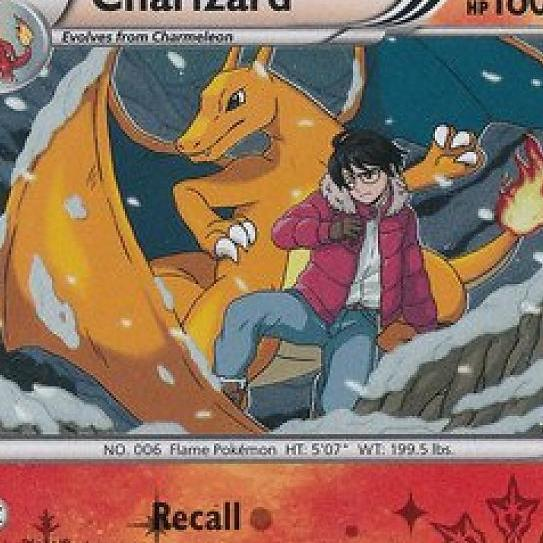

Pokemon type is: fire
freeze-customLR
fire:      24.92%	water:     23.93%	normal:    18.25%	electric:  9.94%	ground:    3.67%	
15Epochs-noFreeze-CrossE
fire:      83.17%	dragon:    4.83%	dark:      4.67%	electric:  2.54%	rock:      1.14%	
no-pretrain-customLR
steel:     15.07%	rock:      10.41%	psychic:   10.03%	water:     9.20%	electric:  8.74%	


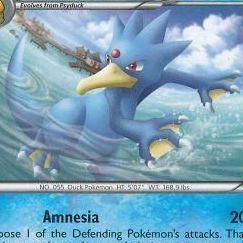

Pokemon type is: water
freeze-customLR
water:     56.39%	bug:       13.63%	dragon:    6.00%	ice:       4.98%	steel:     4.07%	
15Epochs-noFreeze-CrossE
water:     99.64%	ice:       0.15%	dragon:    0.06%	fighting:  0.06%	rock:      0.04%	
no-pretrain-customLR
water:     61.18%	dragon:    8.20%	normal:    6.95%	electric:  5.67%	fighting:  3.53%	


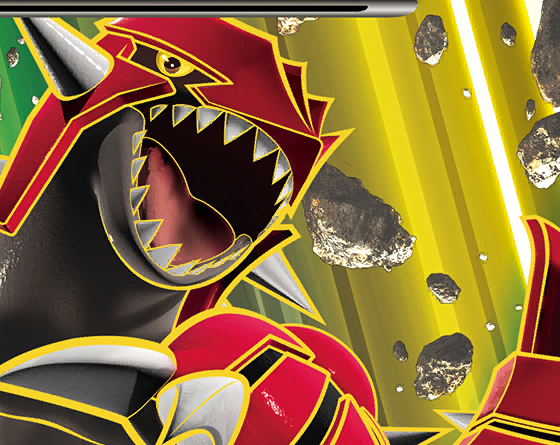

Pokemon type is: ground
freeze-customLR
psychic:   29.78%	electric:  15.51%	dragon:    11.31%	normal:    9.32%	ground:    7.30%	
15Epochs-noFreeze-CrossE
dark:      50.27%	dragon:    12.44%	water:     9.65%	electric:  9.31%	bug:       7.58%	
no-pretrain-customLR
dark:      23.40%	psychic:   17.87%	ground:    8.71%	bug:       7.95%	ghost:     7.32%	


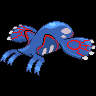

Pokemon type is: water
freeze-customLR
water:     50.82%	dark:      10.69%	dragon:    7.44%	normal:    6.45%	fire:      5.85%	
15Epochs-noFreeze-CrossE
water:     98.53%	dragon:    0.82%	poison:    0.20%	normal:    0.12%	bug:       0.12%	
no-pretrain-customLR
poison:    15.60%	ghost:     13.60%	psychic:   11.19%	dark:      10.22%	water:     9.76%	


In [16]:
net_list = ["./saved-models/freeze-customLR.pt", "./saved-models/15Epochs-noFreeze-CrossE.pt", "./saved-models/no-pretrain-customLR.pt"]

for pokemon in test_pokemon_list:
    make_prediction(pokemon, net_list)